In [25]:
import pandas as pd

# 데이터 불러오기, \s+ 는 공백이 하나 이상이라는 뜻
feature_name_df = pd.read_csv("../data files/human_activity/features.txt",sep = '\s+', header = None, names = ['column_index','column_name'])

feature_name = feature_name_df.iloc[:,1].values.tolist()

# feature 10개만 추출
print(feature_name[:10])

['tBodyAcc-mean()-X', 'tBodyAcc-mean()-Y', 'tBodyAcc-mean()-Z', 'tBodyAcc-std()-X', 'tBodyAcc-std()-Y', 'tBodyAcc-std()-Z', 'tBodyAcc-mad()-X', 'tBodyAcc-mad()-Y', 'tBodyAcc-mad()-Z', 'tBodyAcc-max()-X']


In [26]:
# 중복된 피쳐명 확인
feature_dup_df = feature_name_df.groupby('column_name').count()
print(feature_dup_df[feature_dup_df['column_index']>1].count())
feature_dup_df[feature_dup_df['column_index']>1].head()

column_index    42
dtype: int64


,column_index
column_name,
"fBodyAcc-bandsEnergy()-1,16",3
"fBodyAcc-bandsEnergy()-1,24",3
"fBodyAcc-bandsEnergy()-1,8",3
"fBodyAcc-bandsEnergy()-17,24",3
"fBodyAcc-bandsEnergy()-17,32",3


In [27]:
# 중복된 feature에 인덱스를 붙여 중복을 피하게 하는 함수 생성
def get_new_feature_name(old_feature_name_df):
    # cumcount 함수를 사용하여 몇번째 중복인지 확인. cumcount는 중복이 발생할경우 1씩 올라간다.
    feature_dup_df = pd.DataFrame(data=old_feature_name_df.groupby('column_name').cumcount(),columns=['dup_cnt'])

    # 인덱스를 새로 추가
    feature_dup_df = feature_dup_df.reset_index()

    # feature name이 들어있는 data frame과 중복 feature 정보가 들어있는 data frame을 index 기준으로 모든 행을 병합
    new_feature_name_df = pd.merge(old_feature_name_df.reset_index(),feature_dup_df,how='outer')

    # 중복되는 feature name에 숫자 부여. 숫자는 dup_cnt에 의해 중복된 순서만큼 부여됨. 예를들어 2번째 중복이면 '_2'가 부여됨
    new_feature_name_df['column_name'] = new_feature_name_df[['column_name','dup_cnt']].apply(lambda x : x[0]+'_'+str(x[1]) if x[1] > 0 else x[0], axis =1)

    # index는 필요없으니 삭제함.
    new_feature_name_df = new_feature_name_df.drop(['index'],axis=1)
    return new_feature_name_df

In [28]:
import pandas as pd

def get_human_dataset():
    # 각 데이터파일들은 공백으로 분리되어 있기 때문에 공백문자를 sep로 할당.
    feature_name_df = pd.read_csv('../data files/human_activity/features.txt',sep='\s+',header=None,names=['column_index','column_name'])
    
    # 중복된 feature명을 수정
    new_feature_name_df = get_new_feature_name(feature_name_df)

    # data frame에 피처명을 컬럼으로 부여하기위해 리스트 객체로 다시 변환 모든 feature name은 1번째 열에 있음.
    feature_name = new_feature_name_df.iloc[:,1].values.tolist()

    # 학습 feature 데이터 셋과 테스트 feature 데이터를 dataframe으로 로딩. 컬럼은  feature_name 적용
    x_train = pd.read_csv('../data files/human_activity/train/X_train.txt',sep='\s+',names=feature_name)
    x_test = pd.read_csv('../data files/human_activity/test/X_test.txt',sep='\s+',names=feature_name)

    # 학습 label과 테스트 label 데이터를 data frame으로 로딩하고 컬럼명은 action으로 부여
    y_train = pd.read_csv('../data files/human_activity/train/y_train.txt',sep='\s+',names=['action'])
    y_test = pd.read_csv('../data files/human_activity/test/y_test.txt',sep='\s+',names=['action'])

    # 로드된 학습/테스트용 데이터프레임을 모두 반환
    return x_train,x_test,y_train,y_test

x_train, x_test, y_train, y_test = get_human_dataset()

In [30]:
print(y_train['action'].value_counts())

6    1407
5    1374
4    1286
1    1226
2    1073
3     986
Name: action, dtype: int64


In [31]:
print(x_train.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7352 entries, 0 to 7351
Columns: 561 entries, tBodyAcc-mean()-X to angle(Z,gravityMean)
dtypes: float64(561)
memory usage: 31.5 MB
None


In [32]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV

# decision tree 객체 생성
dt_clf = DecisionTreeClassifier(random_state=56)

# 하이퍼 파라미터 설정
params = {'max_depth' : [6,8,10,12,16,20,24]}

# grid search cv
grid_cv = GridSearchCV(dt_clf, param_grid= params, scoring='accuracy', cv=5, verbose=1)
grid_cv.fit(x_train,y_train)

print("최적 정확도 수치 : {:.4f}".format(grid_cv.best_score_))
print("최적 파라미터 : ",grid_cv.best_params_)

Fitting 5 folds for each of 7 candidates, totalling 35 fits
최적 정확도 수치 : 0.8558
최적 파라미터 :  {'max_depth': 8}


In [35]:
# cv의 결과를 data frame으로 생성
cv_result_df = pd.DataFrame(grid_cv.cv_results_)

# max_depth 파라미터 값과 그 때의 정확도
cv_result_df[['param_max_depth','mean_test_score']]

,param_max_depth,mean_test_score
0,6,0.847663
1,8,0.855830
2,10,0.848216
3,12,0.846175
4,16,0.849847
5,20,0.852160
6,24,0.853112


In [36]:
from sklearn.metrics import accuracy_score

# 최적 모델을 저장
best_dt_clf = grid_cv.best_estimator_

# test set에 대해서 성능평가
pred1 = best_dt_clf.predict(x_test)
accuracy = accuracy_score(y_test,pred1)
print("decision tree predict accuracy : {:.4f}".format(accuracy))

decision tree predict accuracy : 0.8724


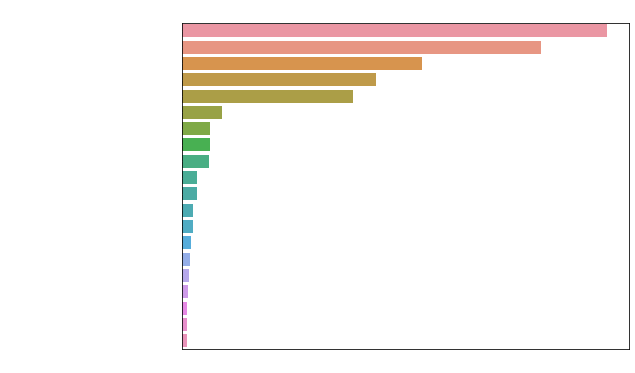

In [40]:
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

# feature importance 저장
ftr_importance_values = best_dt_clf.feature_importances_

# 정렬과 그래프 표현을 용이하게 하기 위해 시리즈로 변환
ftr_importance_values = pd.Series(ftr_importance_values, index=x_train.columns)

# 중요도값 순으로 정렬 후 그래프 출력
ftr_top20 = ftr_importance_values.sort_values(ascending=False)[:20]
plt.figure(figsize=(8,6))
plt.title("Feature Importance Top 20",color = 'white')
plt.tick_params(color = "white", colors = "white")
sns.barplot(x=ftr_top20, y=ftr_top20.index)
plt.show()